In [1]:
# Prelimiaries: Install Gerrychain
# !pip install gerrychain

4/wQG8qOFHR9fTDqOwu2kFX0c6OvjB4dnG9TIKceAAy8kiDYnHuHIvMio

In [2]:
#from google.colab import files
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Required packages
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, grid)
import pandas as pd
import numpy as np
# import geopandas as gp
import networkx as nx
import matplotlib.pyplot as plt
# from functools import partial
from tqdm.auto import tqdm
import pickle

In [4]:
# In this cell I have defined functions for calculating Polsby-Popper and population max-min for a grid object

def plot_districts(grid1, save=False, savetitle=None):
  """
  Plots the districts of a Grid object.
  
  Parameters:
    grid1: a Networkx Graph object, built as a GerryChain grid
  """
  # Get a sequence of assignments (rather than the stored dictionary)
  districts = np.array([grid1.assignment[node] for node in grid1.graph.nodes()])
  
  # The Kamada-Kawai method for nx drawing works best in this case
  nx.drawing.nx_pylab.draw_kamada_kawai(grid1.graph, node_size=20, node_color=districts)
  if save: plt.savefig(savetitle+'.png', dpi=300)

def polsby_popper_grid(grid1):
  """
  Computes the Polsby-Popper score for each district in the grid.

  Parameters:
    grid1: a Networkx Graph object, built as a GerryChain grid
  
  Returns:
    scores (ndarray): The scores of each district in the grid

  """
  # Set parameters
  s = set(grid1.assignment.values())
  n = len(s)
  perimeters = np.zeros(n)
  areas = np.array([sum(grid1.graph.nodes[node]['area'] for node in grid1.graph.nodes if grid1.assignment[node] == i) for i in s])
  
  # Iterate through each node in the graph
  for node1 in grid1.graph.nodes:
    district = grid1.assignment[node1]
    if grid1.graph.nodes[node1]['boundary_node']:
      # Perimeter along boundary
      perimeters[district] += grid1.graph.nodes[node1]['boundary_perim']
    for node2 in grid1.graph[node1].keys():
      if district != grid1.assignment[node2]:
        # Internal perimeter
        perimeters[district] += grid1.graph[node1][node2]['shared_perim']
  
  # Compute the Polsby-Popper score for each district
  return 4*np.pi*areas/perimeters**2

polsby_popper_av = lambda grid1: np.mean(polsby_popper_grid(grid1))

def district_populations(grid1):
    """
    Computes the populations the districts in a grid.

    Parameters:
      grid1: a Networkx Graph object, built as a GerryChain grid

    Returns:
      pops (ndarray)
    """
    # Set parameters
    s = set(grid1.assignment.values()) 
    n = len(s)
    pops = np.zeros(n)

    # Iterate through each node and tally its population in the appropriate index of "populations"
    for node in grid1.graph.nodes:
      pops[grid1.assignment[node]] += grid1.graph.nodes[node]["population"]

    return pops

def population_maxmin(grid1):
    """
    Computes the absolute difference between the populations of the most populous and least populous districts in a grid.

    Parameters:
      grid1: a Networkx Graph object, built as a GerryChain grid
      relative: if True, returns difference as a percentage of average district population

    Returns:
      maxmin (int): The largest population difference. Returns a float (percentage) iff relative is True.
    """
    pops = district_populations(grid1)

    # Perform calculations
    av = np.mean(pops)
    maxmin = np.max(pops) - np.min(pops)

    # Return the difference of the maximum and minimum populations
    return maxmin/av

In [5]:
# This is how to build a cusom acceptance function to work with GerryChain's MarkovChain object

class CustomAccept:
    def __init__(self, weights):
      """
      Initialize an acceptance function with a particular set of weights for
      0) Compactness (Polsby-Popper)
      1) Population Max-min 

      Parameters:
        weights (ndarray): Length 2 ndarray specifying weights for the two measures above
                          Larger weights indicate greater importance
        k (float): strictness of the acceptance function
      """
      # User-defined parameter
      self.weights = weights

    def fitness(self, grid1):
      """
      Determines the absolute fitness of a partition in terms of its compactness 
      and population max-min, using the given weights and scaling.

      Parameters:
        grid1: a Networkx Graph object, built as a GerryChain grid

      Returns:
        w (float): >= 0, a float indicating the "fitness" of the partition. 0 is best
      """
      # Get raw scores
      if "polsby_popper" in grid1.updaters:
        pp = np.mean(list(grid1["polsby_popper"].values()))
      elif "my_polsby_popper" in grid1.updaters:
        pp = np.mean(grid1["my_polsby_popper"])
      else:
        pp = polsby_popper_av(grid1)

      if "pop_maxmin" in grid1.updaters:
        mm = grid1["pop_maxmin"]
      elif "pops" in grid1.updaters:
        p = grid1["pops"]
        mm = (np.max(p)-np.min(p))/np.mean(p)
      else:
        mm = population_maxmin(grid1)

      # Calculate our weighted coefficient (lower value is better)
      return np.sum(self.weights * np.array([1-pp, mm]))

      # Subtract pp from 1 so that good scores are represented by 0

    def __call__(self, grid1):
      """
      A probabilistic acceptance function which calculates how acceptable a 
      partition is and returns a boolean value indicating whether or not to accept 
      the partition. 

      Parameters:
        grid1: a Networkx Graph object, built as a GerryChain grid
        absolute (bool): default True; whether to calculate absolute fitness or 
                        fitness relative to the previous partition.

      Returns:
        accept (bool): True or False (whether to accept the grid)
      """

      # Use probabilistic acceptance
      return np.exp(self.fitness(grid1.parent)-self.fitness(grid1)) > np.random.random(1)

      # If the new partition is "better" then it will be accepted with probability 1
      # Otherwise, there is some probability that it will be rejected

C:\Users\Jacob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


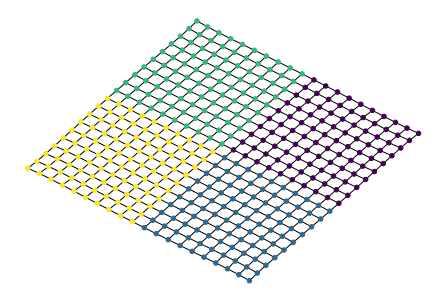

In [6]:
# Create and plot the grid and its initial partition
grid1 = grid.Grid((20,20), updaters={"pops": district_populations})
plot_districts(grid1, save=True, savetitle="default_grid")

In [7]:
polsby_popper_grid(grid1)

array([0.78539816, 0.78539816, 0.78539816, 0.78539816])

In [8]:
district_populations(grid1), population_maxmin(grid1)

(array([100., 100., 100., 100.]), 0.0)

In [28]:
# Create a Markov Chain for single flips based on this grid, with a uniform acceptance criterion
chain1 = MarkovChain(
    proposal = proposals.propose_random_flip,
    constraints=[constraints.single_flip_contiguous],
    accept=accept.always_accept,
    initial_state=grid1,
    total_steps=10000
)

In [10]:
# Create a data frame of scores from a chain (generally about 1 min for 1e4 iterations)
def record_pp_mm(chain):
  """
  Create a pd.DataFrame containing the polsby-popper and population_max_min data for each iteration in the Markov Chain
  """
  return pd.DataFrame([ np.concatenate((np.array(list(partition["polsby_popper"].values())), partition["pops"])) for partition in tqdm(chain) ])

In [11]:
def plot_statistics_grid(d, acceptance_type="Uniform Acceptance", save=False, savetitle=None):
  """
  Makes 4 plots to describe how compactness and population equality change as the 
  Markov chain iterates, and then prints out statistics for Polsby-Popper and 
  Population Max-Min.

  Parameters:
    d (pd.DataFrame): a data frame describing the Polsby-Popper and pop max-min statistics at each iteration

  Returns:
    pp (float): The mean mean Polsby-Popper score over the DataFrame
    mm (float): The mean relative max-min population score over the DataFrame
  """
  # Plot the Polsby-Popper score of each district
  for i in range(4):
    plt.plot(d.iloc[:, i], label="District {}".format(i))
    plt.title("Degradation of Polsby-Popper Scores with {}".format(acceptance_type))
    plt.ylabel("Polsy-Popper Score")
    plt.xlabel("Iteration")
    plt.legend(loc="upper right")
  
  if save: plt.savefig('pps-' + savetitle + '.png', dpi=300)
  plt.show()
  

  # Plot the population of each district
  for i in range(4):
    plt.plot(d.iloc[:, i+4], label="District {}".format(i))
    plt.title("Loss of Population Proportionality with {}".format(acceptance_type))
    plt.ylabel("Population")
    plt.xlabel("Iteration")
    plt.legend(loc="upper right")
    
  if save: plt.savefig('pops-' + savetitle + '.png', dpi=300)
  plt.show()

  # Plot the mean Polsby-Popper score at each iteration
  plt.plot(np.mean(d.iloc[:, :4], axis=1), label="Mean Score")
  plt.title("Degradation of Mean Polsby-Popper Score with {}".format(acceptance_type))
  plt.ylabel("Polsy-Popper Score")
  plt.xlabel("Iteration")
  plt.legend(loc="upper right")

  if save: plt.savefig('pp_av-' + savetitle + '.png', dpi=300)
  plt.show()

  # Plot the population max-min at each iteration
  plt.plot((np.max(d.iloc[:, 4:], axis=1)-np.min(d.iloc[:, 4:], axis=1))/100, label="Relative Max-Min")
  plt.title("Loss of Population Proportionality with {}".format(acceptance_type))
  plt.ylabel("Population")
  plt.xlabel("Iteration")
  plt.legend(loc="upper right")

  if save: plt.savefig('pop_av-' + savetitle + '.png', dpi=300)
  plt.show()

  # Calculate some statistics

  # Mean Polsby-Popper
  print("Polsby-Popper Scores")
  c1 = d.iloc[:, :4].mean(axis=1)
  print(c1.describe())

  # Population max-min
  print("Population Max-Min Scores")
  c2 = (np.max(d.iloc[:, 4:], axis=1)-np.min(d.iloc[:, 4:], axis=1))/100
  print(c2.describe())

  return c1.mean(), c2.mean()

In [12]:
def percent_acceptance(d):
  counter = 0
  for i in range(1, d.shape[0]):
    if np.allclose(d.iloc[i, :], d.iloc[i-1, :]):
      counter += 1
  return (d.shape[0]-counter)/d.shape[0]

In [44]:
chain = MarkovChain(
    proposal = proposals.propose_random_flip,
    constraints=[constraints.single_flip_contiguous],
    accept=CustomAccept(20*np.array([1,1])),
    initial_state=grid1,
    total_steps=10000
)

In [45]:
chain = chain.__iter__()

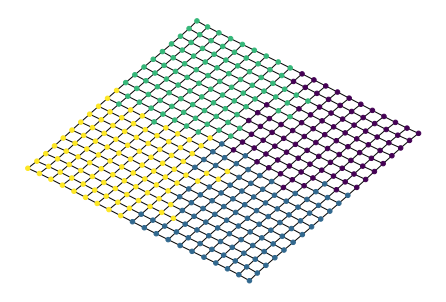

In [47]:
for i in range(100):
    partition = next(chain)
plot_districts(partition, save = True, savetitle = 'grid_state1')

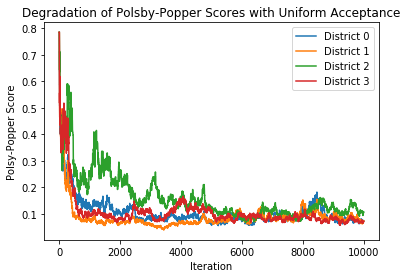

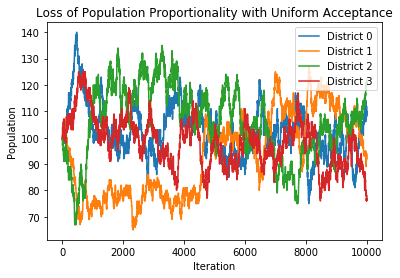

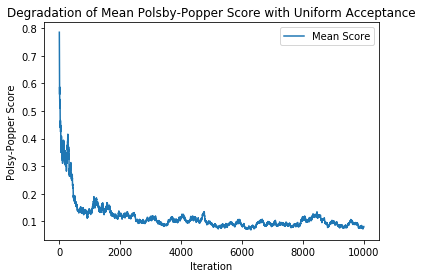

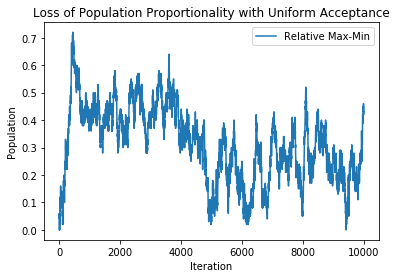

Polsby-Popper Scores
count    10000.000000
mean         0.114984
std          0.056984
min          0.068769
25%          0.088299
50%          0.099955
75%          0.118957
max          0.785398
dtype: float64
Population Max-Min Scores
count    10000.000000
mean         0.313529
std          0.135411
min          0.000000
25%          0.210000
50%          0.320000
75%          0.410000
max          0.720000
dtype: float64


(0.11498392625802935, 0.3135289999999967)

In [13]:
d = record_pp_mm(chain1)
plot_statistics_grid(d, save = True, savetitle='uniform_acceptance')

In [14]:
percent_acceptance(d)

1.0


0.3219


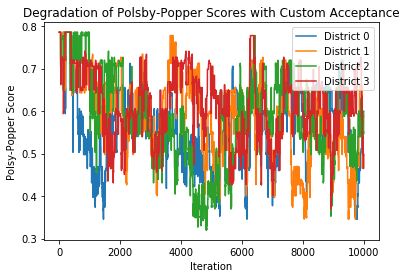

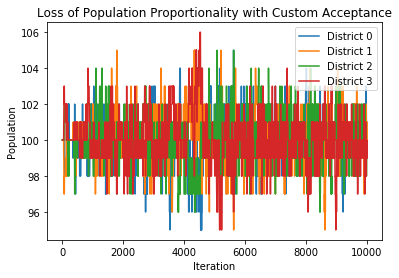

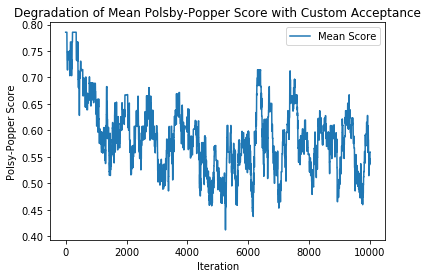

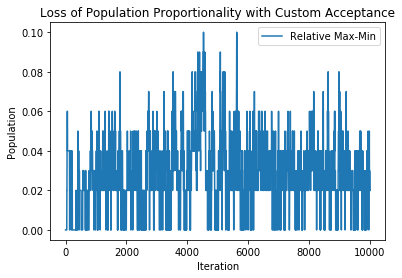

Polsby-Popper Scores
count    10000.000000
mean         0.588598
std          0.066176
min          0.411906
25%          0.546598
50%          0.584304
75%          0.624735
max          0.785398
dtype: float64
Population Max-Min Scores
count    10000.000000
mean         0.027456
std          0.017949
min          0.000000
25%          0.020000
50%          0.020000
75%          0.040000
max          0.100000
dtype: float64


(0.5885978907607977, 0.02745600000000091)

In [15]:
# Create a Markov Chain with a relative acceptance criterion that always accepts "better" iterations and probabilistically accepts worse ones
chain2 = MarkovChain(
    proposal = proposals.propose_random_flip,
    constraints=[constraints.single_flip_contiguous],
    accept=CustomAccept(100*np.array([1,1])),
    initial_state=grid1,
    total_steps=10000
)

# Run the chain and analyze the resulting data
d2 = record_pp_mm(chain2)
print(percent_acceptance(d2))
plot_statistics_grid(d2, "Custom Acceptance", save=True, savetitle='custom_acceptance1')

In [16]:
import inspect
print(inspect.getsource(MarkovChain))
print(inspect.getsource(Partition))
print(inspect.getsource(grid.Grid))
print(inspect.getsource(proposals.propose_random_flip))
print(inspect.getsource(updaters.cut_edges))

class MarkovChain:
    """
    MarkovChain is an iterator that allows the user to iterate over the states
    of a Markov chain run.

    Example usage:

    .. code-block:: python

        chain = MarkovChain(proposal, constraints, accept, initial_state, total_steps)
        for state in chain:
            # Do whatever you want - print output, compute scores, ...

    """

    def __init__(self, proposal, constraints, accept, initial_state, total_steps):
        """
        :param proposal: Function proposing the next state from the current state.
        :param constraints: A function with signature ``Partition -> bool`` determining whether
            the proposed next state is valid (passes all binary constraints). Usually
            this is a :class:`~gerrychain.constraints.Validator` class instance.
        :param accept: Function accepting or rejecting the proposed state. In the most basic
            use case, this always returns ``True``. But if the user wanted to use a
    


class Grid(Partition):
    """
    The :class:`Grid` class represents a grid partitioned into districts.
    It is useful for running little experiments with GerryChain without needing to do
    any data processing or cleaning to get started.

    Example usage::

        grid = Grid((10,10))

    The nodes of ``grid.graph`` are labelled by tuples ``(i,j)``, for ``0 <= i <= 10``
    and ``0 <= j <= 10``. Each node has an ``area`` of 1 and each edge has ``shared_perim`` 1.
    """

    default_updaters = {
        "cut_edges": cut_edges,
        "population": Tally("population"),
        "perimeter": perimeter,
        "exterior_boundaries": exterior_boundaries,
        "interior_boundaries": interior_boundaries,
        "boundary_nodes": boundary_nodes,
        "area": Tally("area", alias="area"),
        "polsby_popper": polsby_popper,
        "cut_edges_by_part": cut_edges_by_part,
    }

    def __init__(
        self,
        dimensions=None,
        with_diagonals=False,
        

In [17]:
class MarkovChainLite:
    """
    MarkovChain is an iterator that allows the user to iterate over the states
    of a Markov chain run.

    Example usage:

    .. code-block:: python

        chain = MarkovChain(proposal, constraints, accept, initial_state, total_steps)
        for state in chain:
            # Do whatever you want - print output, compute scores, ...

    """

    def __init__(self, proposal, constraints, accept, initial_state, total_steps):
        """
        :param proposal: Function proposing the next state from the current state.
        :param constraints: A function with signature ``Partition -> bool`` determining whether
            the proposed next state is valid (passes all binary constraints). Usually
            this is a :class:`~gerrychain.constraints.Validator` class instance.
        :param accept: Function accepting or rejecting the proposed state. In the most basic
            use case, this always returns ``True``. But if the user wanted to use a
            Metropolis-Hastings acceptance rule, this is where you would implement it.
        :param initial_state: Initial :class:`gerrychain.partition.Partition` class.
        :param total_steps: Number of steps to run.

        """
        if callable(constraints):
            is_valid = constraints
        else:
            is_valid = Validator(constraints)

        if not is_valid(initial_state):
            failed = [
                constraint
                for constraint in is_valid.constraints
                if not constraint(initial_state)
            ]
            message = (
                "The given initial_state is not valid according is_valid. "
                "The failed constraints were: " + ",".join([f.__name__ for f in failed])
            )
            raise ValueError(message)

        self.proposal = proposal
        self.is_valid = is_valid
        self.accept = accept
        self.total_steps = total_steps
        self.initial_state = initial_state
        self.state = initial_state

    def __iter__(self):
        self.counter = 0
        self.state = self.initial_state
        return self

    def __next__(self):
        if self.counter == 0:
            self.counter += 1
            return self.state

        while self.counter < self.total_steps:
            proposed_next_state = self.proposal(self.state)
            # Erase the parent of the parent, to avoid memory leak
            self.state.parent = None

            self.counter += 1 # Count at this step
            if self.is_valid(proposed_next_state):
                if self.accept(proposed_next_state):
                    self.state = proposed_next_state
            return self.state

        raise StopIteration

    def __len__(self):
        return self.total_steps

    def __repr__(self):
        return "<MarkovChain [{} steps]>".format(len(self))

In [18]:
def ring(n, updaters=None):
  """
  Creates and returns a special ring partition of length n. All of the nodes are 
  considered boundary nodes, and all given boundary perimeter 2pi/n, shared perimeter 1,
  area pi/n, and population 1.

  Parameters:
    n (int): the number of nodes in the ring

  Returns:
    p (gerrychain.Partition): a chainable Partition object with two assigned districts
  """
  # Initializes the graph
  g = nx.Graph()
  
  # Add nodes and edges with the correct attributes
  g.add_nodes_from(list(range(n)), area = np.pi/n, boundary_node = True, boundary_perim = 2*np.pi/n, population = 1)
  g.add_edges_from([(i, i+1) for i in range(n-1)], shared_perim=1)
  
  # Complete the ring
  g.add_edge(n-1, 0, shared_perim=1)

  # Assign ceil(n/2) nodes to district 0 and floor(n/2) nodes to district 1
  a = {i: int(i/((n+1)//2)) for i in range(n)}

  # Create and return a partition object
  return Partition(g, a, updaters)

# Return the state of the ring
state = lambda ring1: int(district_populations(ring1)[0])

25


C:\Users\Jacob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


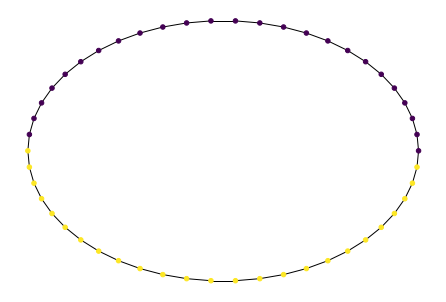

In [19]:
r = ring(50, updaters={"state":state})
print(r["state"])
plot_districts(r, save=True, savetitle="default_ring")

In [20]:
r2 = ring(3)
r2["cut_edges"]

{(0, 2), (1, 2)}

In [21]:
def predict_ring_dist(n, weights, edge_adjustment=False):
  """
  Analytically predicts the pdf of ring states generated by a Gibbs-sampling 
  Markov Chain. 
  """

  # Compute the polsby-popper score analytically
  pp = lambda j: 0.5*j*n/(j+n/np.pi)**2 + 0.5*(n-j)*n/(n-j+n/np.pi)**2

  # Compute the relative pop max-min score analytically
  mm = lambda j: 2*np.abs(2*j-n)/n

  # Compute un-normalized pmf of the expected distribution
  tot = lambda j: np.exp(-np.sum(weights * np.array([1.-pp(j), mm(j)])))

  # Account for edge adjustment
  if edge_adjustment:
    twiddle = lambda j: 0.5 if j == n-1 or j == 1 else 1
    pmf = lambda j: twiddle(j)*tot(j)
  else:
    pmf = tot
      
  # Compute the normalization constant
  N = np.sum([pmf(j) for j in range(1, n)])

  # Return the normalized function
  return lambda j: pmf(j)/N if j != n and j != 0 else 0

In [22]:
def test_on_ring(n, iters, edge_adjustment=False, weights=np.array([1.,1.]), save=False, savetitle=None):
  """
  Test the Gibbs sampling algorithm on a ring of length n with a Markov chain of "iters" iterations.

  Parameters:
    n (int): the length of the "ring" on which to test the Gibbs sampling algorithm
    iters (int): the number of iterations to run the Markov chain
    weights: the weights to use in the custom acceptance function
    k: the scaling constant to use in the custom acceptance function
  """
  # Create the Markov chain
  kwargs = {
    "proposal": proposals.propose_random_flip,
    "constraints": constraints.single_flip_contiguous,
    "accept": CustomAccept(weights),
    "initial_state": ring(n, updaters={"state": state, "my_polsby_popper": polsby_popper_av, "pop_maxmin": population_maxmin}),
    "total_steps": iters
  }
  if edge_adjustment:
    chain5 = MarkovChain(**kwargs)
  else:
    chain5 = MarkovChainLite(**kwargs)

  # Run the Markov chain and record data
  d = pd.DataFrame([ [partition["state"], partition["my_polsby_popper"], partition["pop_maxmin"]] for partition in tqdm(chain5) ], columns=["state", "polsby_popper", "pop_maxmin"])
  print(percent_acceptance(d))

  # Plot the resulting data
  domain = np.linspace(0, n, n+1)
  plt.hist(d["state"], bins=np.linspace(-0.5, n+0.5, n+2), density=True, rwidth=0.5, align="right", label="Generated pmf")
  pmf = predict_ring_dist(n, weights, edge_adjustment)
  plt.bar(domain, np.array([pmf(j) for j in domain]), width=0.5, align="edge", color="red", label="Expected pmf")
  plt.xlabel("State")
  plt.ylabel("Probability Mass")
  plt.title("Expected and Generated Probability Mass Functions for States on a Ring")
  plt.legend(loc="upper left")
  if save: plt.savefig(savetitle+'.png', dpi=300)
  plt.show()

  return d



0.8736


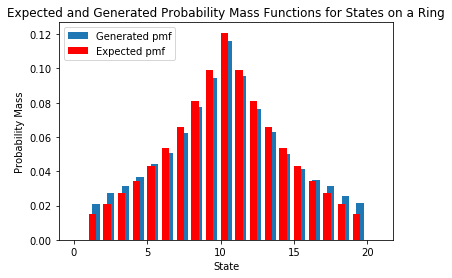

In [23]:
d = test_on_ring(20, 10000, save=True, savetitle="ring_states_20")


0.6495


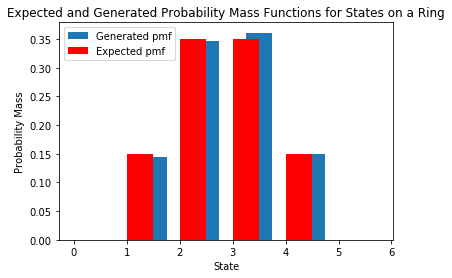

In [24]:
d = test_on_ring(5, 10000, save=True, savetitle="ring_states_5")


0.9714


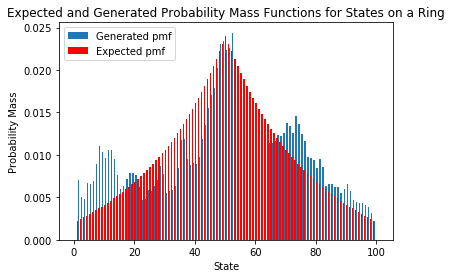

In [25]:
d = test_on_ring(100, 10000, save=True, savetitle="ring_states_100")


0.979


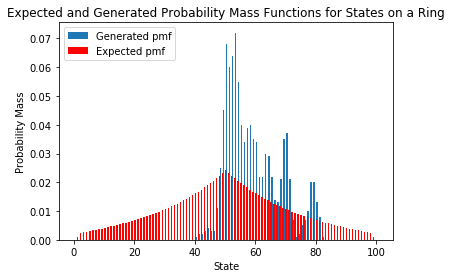

In [26]:
d2 = test_on_ring(100, 1000, edge_adjustment=True)


0.6484


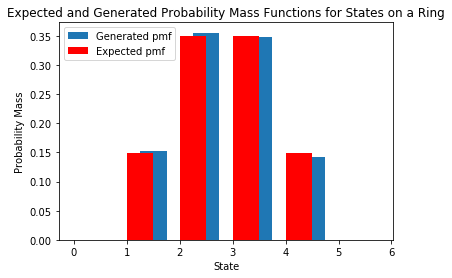

In [27]:
d3 = test_on_ring(5, 10000, edge_adjustment=False)